In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pandas.tools.plotting import scatter_matrix

In [2]:
def data_cleaning_function(filepath):
    '''
    load data into a pandas dataframe from the csv file
    '''
    df_ = pd.read_csv(filepath)
    '''
    Drop the last five columns which were non user data generated when downloading
    data from Salesforce
    '''
    df_ = df_.ix[:3570,:]

    '''
    keep only the data that has DOC numbers
    '''
    df_.dropna(subset =['DOC / Agency #'], inplace= True)

    '''
    create a count of recidivism events for each person
    '''
    recidivism_events = df_.groupby('DOC / Agency #').count()['Recidivism Event Name']
    df_ = df_.drop_duplicates('DOC / Agency #')
    df_.set_index('DOC / Agency #', inplace = True)

    '''
    concat the recidivism count with original data frame
    '''
    clean_df = pd.concat([df_, recidivism_events], axis = 1)

    '''
    rename the columns
    '''
    clean_df.columns= ['full_name', 'recidivism_event_name', 's_code',
           'level_of_service', 'education_level_when_released',
           'gender', 'race_or_ethnicity', 'num_of_children',
           'num_recidivisms']
    '''
    create ordinal values for the education column
    '''
    clean_df['education_level_when_released'] = clean_df['education_level_when_released'].map({'nan': 0,\
        'Passed 8th Grade': 0,'Passed 8th Grade': 1,'GED': 2, 'High School Diploma': 3, 'Some College': 4,\
        'Associates Degree': 5, 'Bachelors Degree': 6})
    return clean_df

clean_df = data_cleaning_function('data/data_with_agencynum.csv')

In [ ]:
df_.tail(10)

In [ ]:
df_.head(10)

In [ ]:
clean_df.columns

In [ ]:
clean_df.education_level_when_released.value_counts()

In [ ]:
clean_df.head()

In [ ]:
clean_df.tail()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe448b36b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe4465905c0>]], dtype=object)

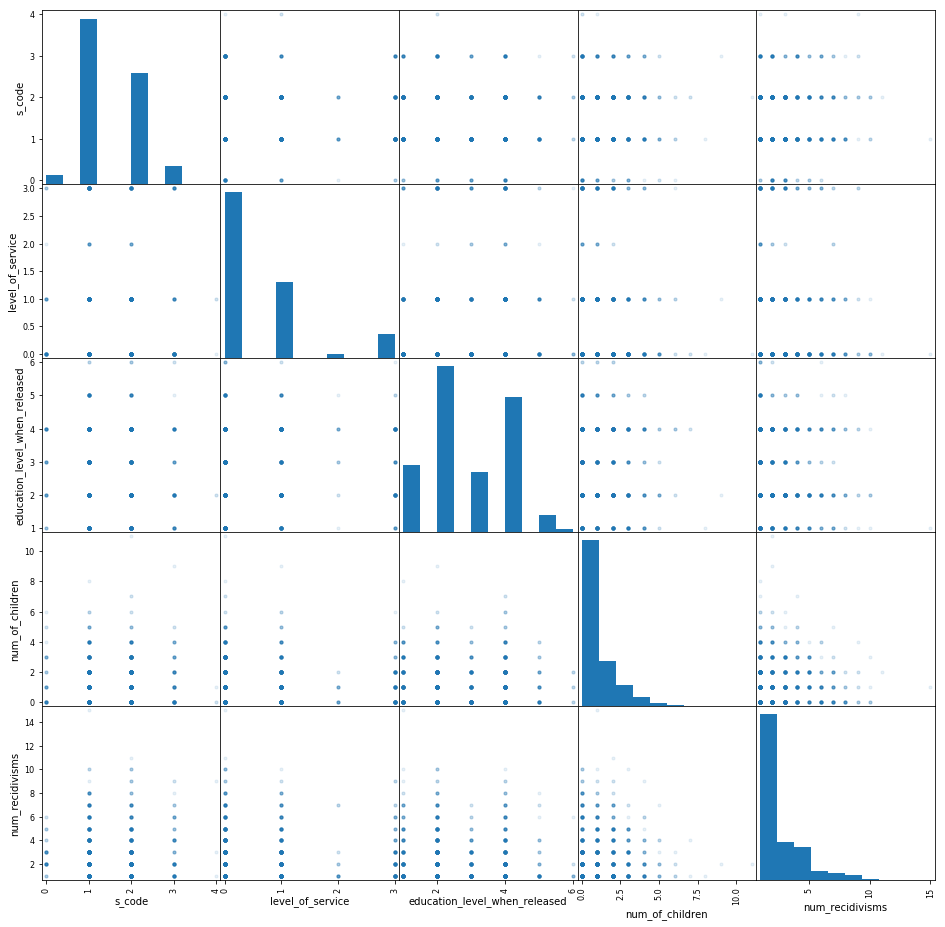

In [3]:
scatter_matrix(clean_df, figsize = (16,16), alpha=0.1)

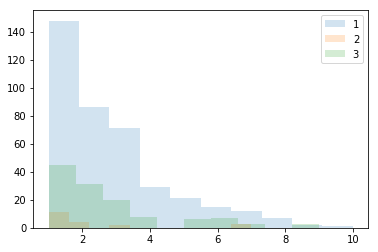

In [4]:
fig, ax = plt.subplots()
for los in range(1,4):
    ax.hist(clean_df[clean_df.level_of_service==los].num_recidivisms, alpha=0.2, label=str(los))
ax.legend()

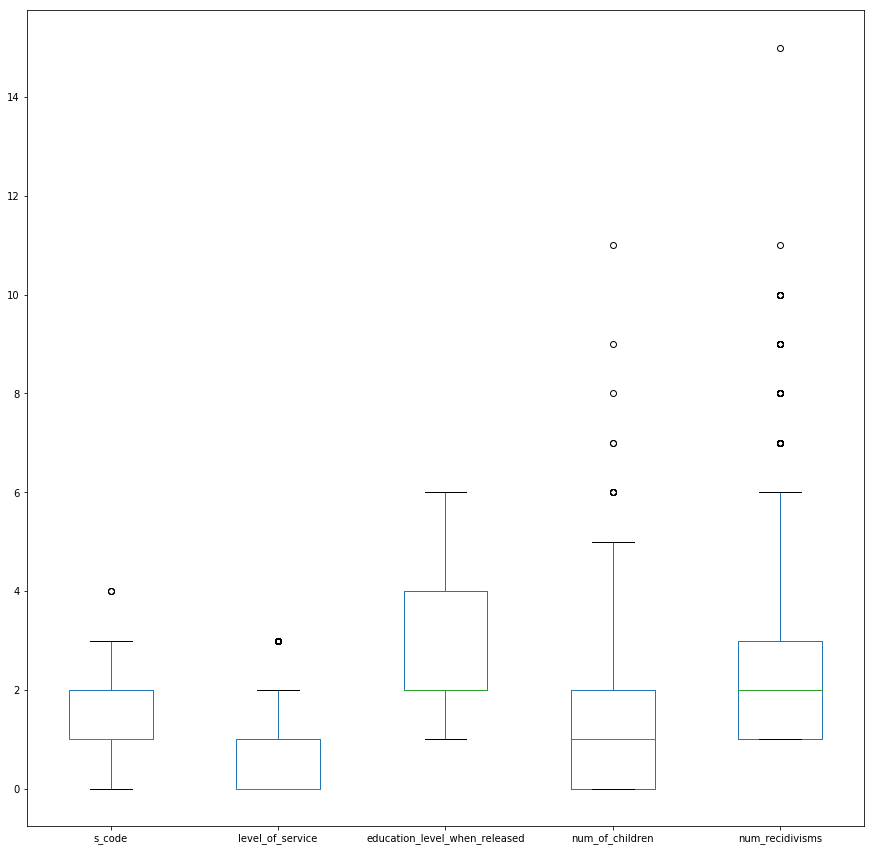

In [5]:
clean_df.plot(kind='box', figsize=(15,15))

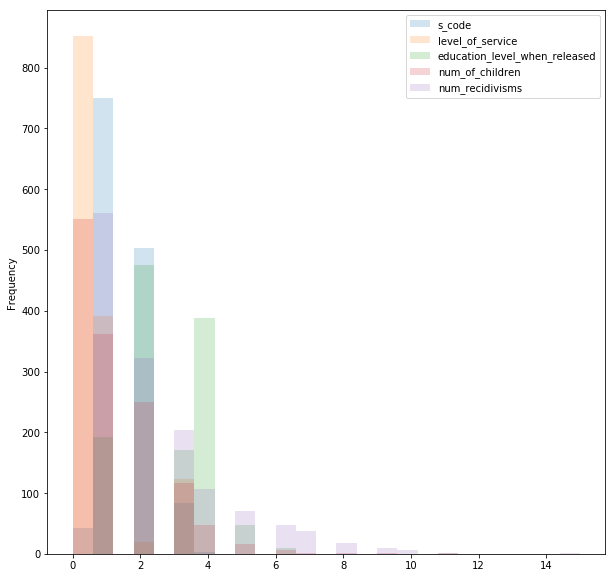

In [7]:
clean_df.plot(bins=25, alpha=0.2, kind='hist', figsize = (10,10))

In [ ]:
clean_df.info()

In [ ]:
clean_df.describe()

In [8]:
dummies = pd.get_dummies(clean_df, columns =['education_level_when_released', 'race_or_ethnicity', 'gender' ])

In [9]:
dummies.drop(['full_name', 'recidivism_event_name'], inplace = True, axis = 1)
x = dummies.dropna(axis = 0)
y  = x['num_recidivisms'] > 1
x.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [12]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(x_train, y_train)
print (rfc_model.score(x_test, y_test))

0.60237388724


In [13]:
gbc = GradientBoostingClassifier()
gbc_model = gbc.fit(x_train, y_train)
print (gbc_model.score(x_test, y_test))

0.649851632047


In [ ]:
clean_df.head()

In [ ]:
clean_df.reset_index(inplace = True)

In [ ]:
clean_df['education_level_when_released'].unique()

## Plotting ROC curves

In [14]:
##Predicting classification probability for each model 
y_predictprob_rfc = rfc_model.predict_proba(x_test)
y_predictprob_gbc = gbc_model.predict_proba(x_test)


In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [17]:
false_positive_rate_rfc, true_positive_rate_rfc, thresholds_rfc = roc_curve(y_test, y_predictprob_rfc[:,1])
false_positive_rate_gbc, true_positive_rate_gbc, thresholds_gbc = roc_curve(y_test, y_predictprob_gbc[:,1])

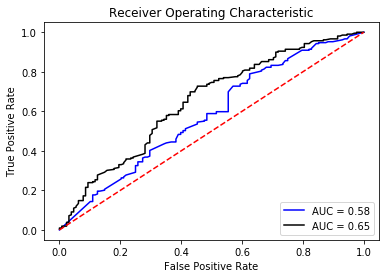

In [18]:
roc_auc_rfc = auc(false_positive_rate_rfc, true_positive_rate_rfc)
roc_auc_gbc = auc(false_positive_rate_gbc, true_positive_rate_gbc)

##Plot ROC

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate_rfc, true_positive_rate_rfc, 'b',
label='AUC = %0.2f'% roc_auc_rfc)

plt.plot(false_positive_rate_gbc, true_positive_rate_gbc, 'k',
label='AUC = %0.2f'% roc_auc_gbc)


plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Basically I have two crappy models!! Bruh!